## Import libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score

%matplotlib inline

## Read in data

In [2]:
housing = pd.read_csv('data/boston_house_prices.csv')
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Update to a cross-validated approach


### TODO:
[x] Do a train-test split
[x] Do cross-validation and regularization
[ ] Estimate parameters using Bootstrapping

In [3]:
features = housing.drop('MEDV', axis=1)
target = housing['MEDV']

In [14]:
# Add in new features
features['RM_sq'] = features['RM']**2
features['log_LSTAT'] = np.log1p(features['LSTAT'])

In [15]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           random_state=42)


In [16]:
scaler = RobustScaler()
lasso_regressor = LassoCV(cv=5)
features_train_scaled = scaler.fit_transform(features_train)
lasso_regressor.fit(features_train_scaled, target_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [17]:
lasso_regressor.alpha_

0.013523912601697196

In [18]:
predicted_train = lasso_regressor.predict(features_train_scaled)

r2_score(target_train, predicted_train)

0.8297803565448099

Let's compare to the test set:

In [19]:
features_test_scaled = scaler.transform(features_test)
predicted_test = lasso_regressor.predict(features_test_scaled)
r2_score(target_test, predicted_test)

0.78342915340775

While working on this, let's look at the coefficients of the `lasso_regressor`. It is common to use lasso (aka L1 regression) to do feature selection, as it tends to set the coefficients of unimportant features to zero (at least more aggressively than ridge does).

In [20]:
lasso_regressor.coef_

array([ -0.49343909,   0.09740161,   0.24643404,   1.95418682,
        -2.40910752, -12.26091411,   0.19847291,  -3.1885817 ,
         2.35290162,  -2.5964    ,  -2.57358679,   0.19610811,
         1.45093206,  14.21010982,  -8.98416019])

None of the coefficients were chosen as unimportant, i.e. Lasso set none of the coefficients to zero. After scaling, the coefficients are more or less comparable. Let's get a ranking of the most important features: 

In [21]:
feature_importance = sorted(zip(lasso_regressor.coef_, features.columns), key=lambda x: abs(x[0]),
                           reverse=True)
for coef, name in feature_importance:
    print(f'{name:10s} {coef:6.4f}')

RM_sq      14.2101
RM         -12.2609
log_LSTAT  -8.9842
DIS        -3.1886
TAX        -2.5964
PTRATIO    -2.5736
NOX        -2.4091
RAD        2.3529
CHAS       1.9542
LSTAT      1.4509
CRIM       -0.4934
INDUS      0.2464
AGE        0.1985
B          0.1961
ZN         0.0974


Let's start organizing results into a table:

| Method | Train $R^2$ | Test $R^2$ |
| --- | --- | --- |
| OLS (Excel) | 0.74064 | N/A |
| OLS (Python)| 0.74064 | N/A |
| LassoCV (Python, scaled) | 0.7477 | 0.6823 |
| LassoCV (Python, scaled, extra features) |0.8298 | 0.7834 |


Our test score is significantly loewr than our training score, suggesting that our model is still 

## Plot of residuals

In Excel, we include a plot of residuals for every feature. We will do the same thing here

In [22]:
# Note this definition of residuals is actually off by a minus sign
# We will correct this in a later commit - this is a deliberate "mistake"
residuals = predicted_train - target_train

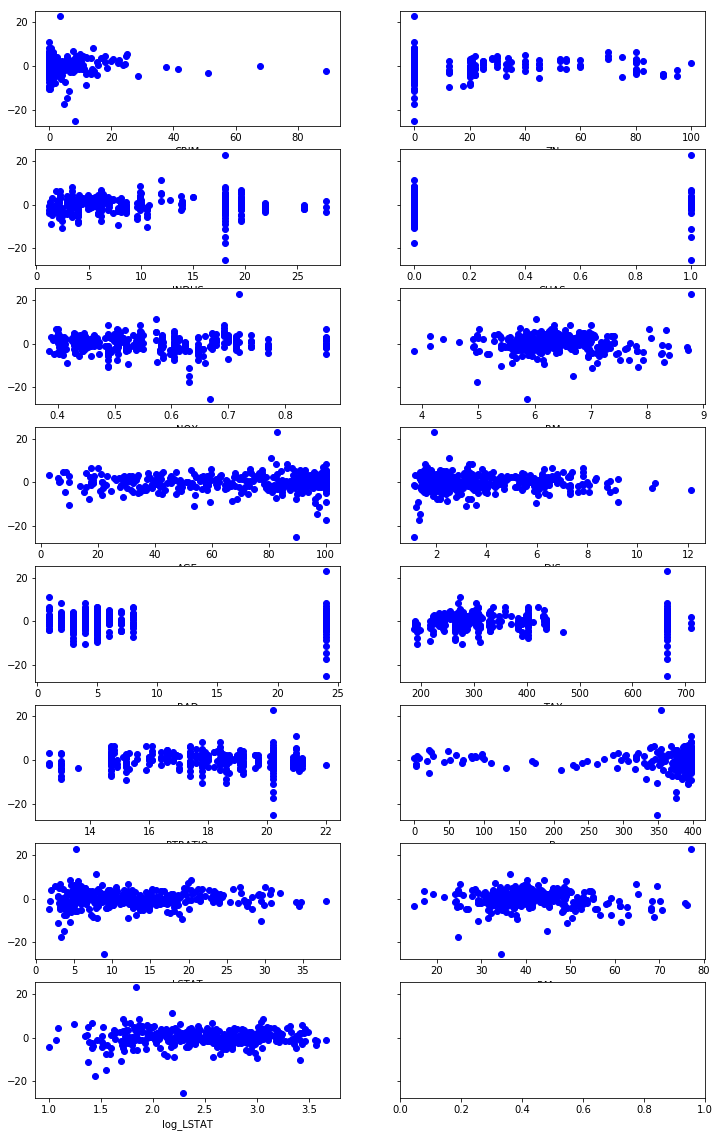

In [23]:
fig, axes = plt.subplots(ncols=2, nrows=len(features.columns)//2 + 1, 
                         sharey=True, squeeze=True, figsize=(12,20))

for index, feature_name in enumerate(features_train.columns):
    feature_values = features_train[feature_name]
    col = index % 2
    row = index // 2
    this_plot = axes[row][col]
    this_plot.plot(feature_values, residuals, 'bo')
    this_plot.set_xlabel(feature_name)